In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [3]:
x_train, y_train,x_test, y_test = load_data()



In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict

def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)
    
    try:
        auc = roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')
    except:
        auc = 0
    auc_df = pd.DataFrame({'AUC': auc}, index=unique_labels)
    
    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})
    
    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])
    
    return result_df

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

def plot_multiclass_roc_curve(dt, x_test, y_test):
    probabilities_dt = dt.predict_proba(x_test)
    roc_auc_scores_dt = []

    plt.figure(figsize=(8, 6))
    unique_labels_dt = np.unique(y_train)

    for i in range(len(unique_labels_dt)):
        fpr_dt, tpr_dt, _ = roc_curve((y_test == unique_labels_dt[i]).astype(int), probabilities_dt[:, i])
        roc_auc_dt = auc(fpr_dt, tpr_dt)
        roc_auc_scores_dt.append(roc_auc_dt)
        plt.plot(fpr_dt, tpr_dt, lw=2, label=f'ROC curve (class {unique_labels_dt[i]}, area = {roc_auc_dt:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for Multiclass Decision Tree')
    plt.legend(loc='lower right')
    plt.show()


In [5]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

dt = DecisionTreeClassifier(max_depth=17,random_state=42)
dt.fit(x_train, y_train) 

DecisionTreeClassifier(max_depth=17, random_state=42)

[Text(0.3784579506110943, 0.9722222222222222, 'x[1264] <= 84.5\ngini = 0.824\nsamples = 9690\nvalue = [210, 2220, 2250, 1410, 1980, 210, 360, 240, 540, 270]'),
 Text(0.16084133660322386, 0.9166666666666666, 'x[983] <= 38.5\ngini = 0.828\nsamples = 4098\nvalue = [11, 336, 451, 1183, 931, 149, 338, 168, 321, 210]'),
 Text(0.03505751475707583, 0.8611111111111112, 'x[1170] <= 22.5\ngini = 0.564\nsamples = 1102\nvalue = [0, 43, 64, 226, 686, 30, 34, 13, 6, 0]'),
 Text(0.008324504313606781, 0.8055555555555556, 'x[982] <= 13.5\ngini = 0.64\nsamples = 333\nvalue = [0, 7, 11, 178, 81, 30, 25, 0, 1, 0]'),
 Text(0.005902830331466626, 0.75, 'x[663] <= 6.0\ngini = 0.028\nsamples = 70\nvalue = [0, 0, 0, 0, 69, 1, 0, 0, 0, 0]'),
 Text(0.004691993340396549, 0.6944444444444444, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]'),
 Text(0.007113667322536704, 0.6944444444444444, 'gini = 0.0\nsamples = 69\nvalue = [0, 0, 0, 0, 69, 0, 0, 0, 0, 0]'),
 Text(0.010746178295746934, 0.75, 'x[794] 

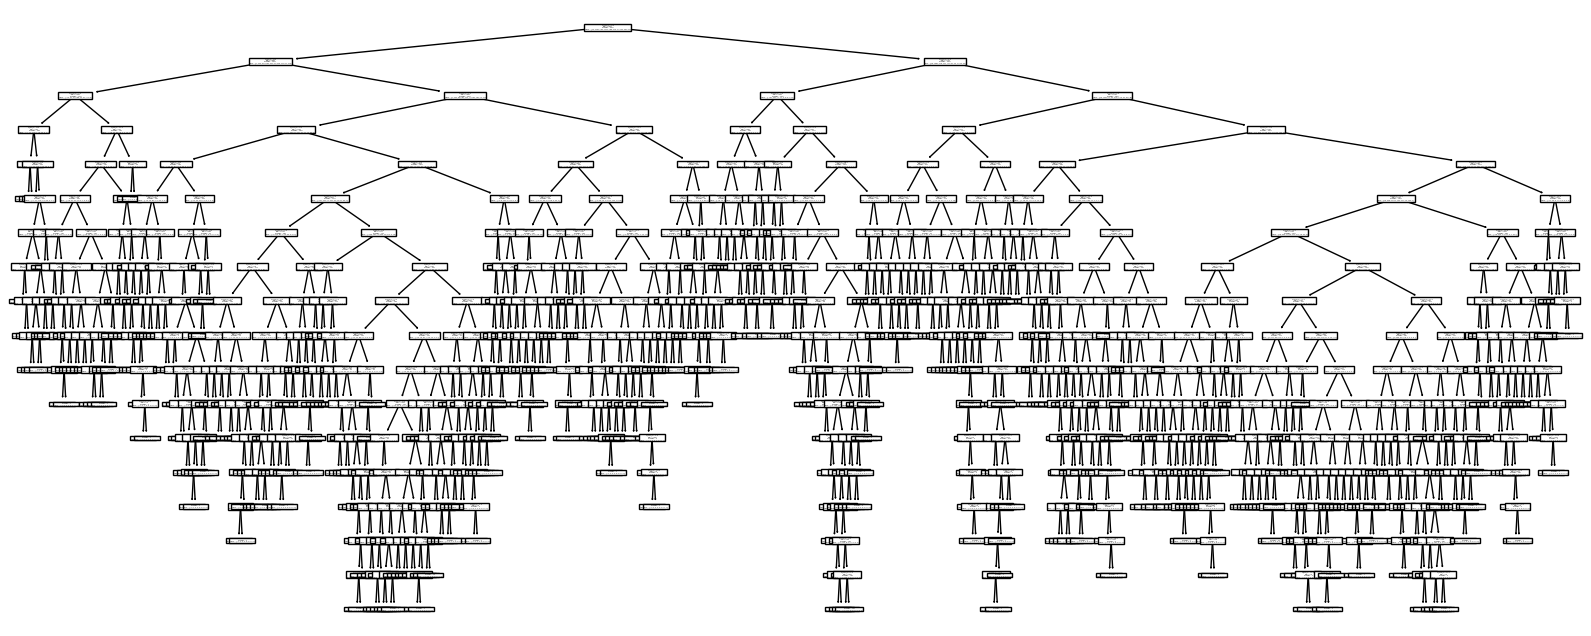

In [6]:
plt.figure(figsize=(20, 8))
plot_tree(dt)

In [7]:
y_pred = dt.predict(x_test)

calculate_metrics_and_mean(x_test, y_test, y_pred, dt)

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC,accuracy,CV mean,CV std
0,0.302326,0.433333,0.356164,0.433333,0.019802,0.980198,0.433333,0.758516,0.694498,0.828479,0.020923
1,0.741357,0.804167,0.771486,0.804167,0.085232,0.914768,0.804167,0.758516,NaN,NaN,NaN
2,0.748042,0.764000,0.755937,0.764000,0.082479,0.917521,0.764000,0.758516,NaN,NaN,NaN
3,0.682028,0.657778,0.669683,0.657778,0.052273,0.947727,0.657778,0.758516,NaN,NaN,NaN
4,0.751592,0.715152,0.732919,0.715152,0.064198,0.935802,0.715152,0.758516,NaN,NaN,NaN
5,0.547170,0.483333,0.513274,0.483333,0.007921,0.992079,0.483333,0.758516,NaN,NaN,NaN
6,0.416667,0.388889,0.402299,0.388889,0.016333,0.983667,0.388889,0.758516,NaN,NaN,NaN
7,0.357143,0.416667,0.384615,0.416667,0.014851,0.985149,0.416667,0.758516,NaN,NaN,NaN
8,0.567568,0.420000,0.482759,0.420000,0.016327,0.983673,0.420000,0.758516,NaN,NaN,NaN
9,0.623377,0.533333,0.574850,0.533333,0.009667,0.990333,0.533333,0.758516,NaN,NaN,NaN


c:\Users\ishaq\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


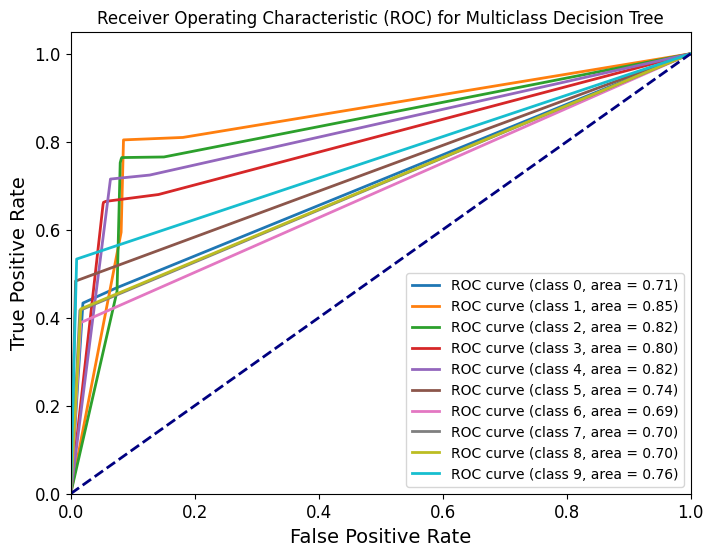

In [37]:
plot_multiclass_roc_curve (dt, x_test, y_test)

Ref: https://colab.research.google.com/drive/1a7ZfYvTSju41AXrEX5570-dFT8zGwVpH?usp=sharing#scrollTo=EPFvRB2v6J4H

In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
pca = PCA(n_components=1000)

x_test_pca = pca.fit_transform(x_test)
x_train_pca = pca.fit_transform(x_train)

In [66]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

dt_pca = DecisionTreeClassifier(max_depth=17)
dt_pca.fit(x_train_pca, y_train) 

DecisionTreeClassifier(max_depth=17)

In [67]:
y_pred = dt_pca.predict(x_test_pca)

calculate_metrics_and_mean(x_test_pca, y_test, y_pred, dt)

c:\Users\ishaq\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# plt.figure(figsize=(20, 8))
# plot_tree(dt_pca)

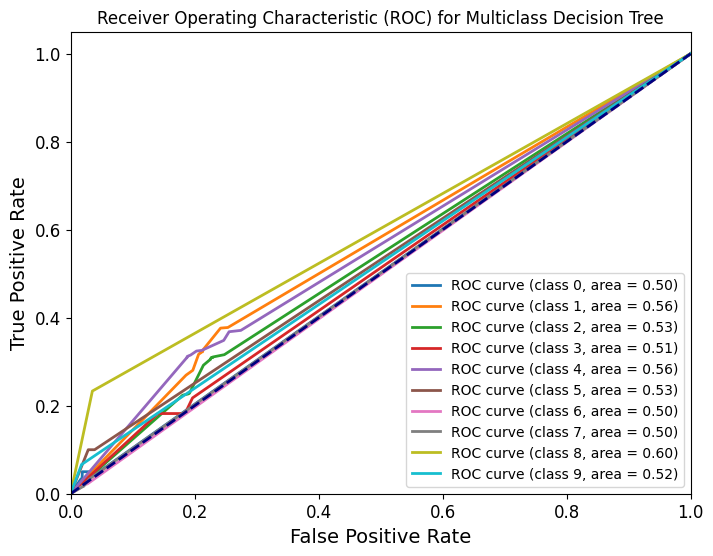

In [ ]:
plot_multiclass_roc_curve (dt_pca, x_test_pca, y_test)